In [72]:
from distutils.command.bdist import show_formats
import qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from quantuminspire.qiskit import QI
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.visualization import plot_histogram 

from time import time
import numpy as np
import utils as u
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
u.set_auth()

In [47]:
def create_calibration_matrix(qubits, qubit_list, backend = QI.get_backend('QX single-node simulator')):
    """
    qubits [int]: number of qubits
    qubit_list [list] = list/array of qubits indexed into the backend
    """
    # create calibration circuits
    qr = QuantumRegister(qubits)
    meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel="cal")
    # create calibration matrix by running calibration
    #backend = QI.get_backend('QX single-node simulator') # replace 'with Starmon-5' later
    job = qiskit.execute(meas_calibs, backend=backend, shots=1024)
    cal_results = job.result()
    meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel="cal")
    return meas_fitter

In [49]:
start_meas_fitter_5 = time()

meas_fitter_5 = [create_calibration_matrix(5, [i], backend = QI.get_backend("Starmon-5")) for i in range(5)]

finish_meas_fitter_5 = time()

print(f"\nElapsed Time: {np.round(finish_meas_fitter_5 - start_meas_fitter_5, 2)} seconds")


Elapsed Time: 461.3 seconds


In [130]:
start_meas_fitter_spin2_5 = time()

meas_fitter_spin2_5 = [create_calibration_matrix(2, [i], backend = QI.get_backend("Spin-2")) for i in range(5)]

finish_meas_fitter_spin2_5 = time()

print(f"\nElapsed Time: {np.round(finish_meas_fitter_spin2_5 - start_meas_fitter_spin2_5, 2)} seconds")

KeyboardInterrupt: 

In [5]:
def apply_measurement_error_mitigation(meas_fitter, raw_counts):
    """
    meas_fitter [qiskit ignis CompleteMeasFitter object]: calibration matrix fitter
    raw_counts [dict]: dictionary of bitstrings with respective counts
    """
    # apply measurement error mitigation via calibration matrix ####
    meas_filter = meas_fitter.filter
    mitigated_results = meas_filter.apply(raw_counts)
    return mitigated_results

In [6]:
basis_to_bit = {"Z" : "1", "X" : "0"}

In [128]:
all_noisy_counts = []
all_mitigated_counts = []

In [92]:
def build_circuit_5(alice_string, bob_bases, qi_backend, n_shots=1024, meas_err_mitig=False):
    if len(alice_string) != len(bob_bases):
        raise IndexError(
            "Length of bit string and length of bases to measure in do not match."
        )
    else:
        length = len(alice_string)

    circuits = []
    known_indices = []
    final_bit_string = ""

    for index in range(0, length, 5):
        reg_len = 5
        if length - index < 5:
            reg_len = length - index
        
        qr = QuantumRegister(reg_len)
        circuit = QuantumCircuit(qr)
        bits = alice_string[index : index + reg_len]
        bases = bob_bases[index : index + reg_len]
        # print("bits:", bits)
        # print("bases:", bases)

        # Step 1: Initialize qubits according to Alice's bit string
        for r in range(reg_len):
            bit = bits[r]
            
            if bit == "0":  # if the bit is 0
                circuit.i(qr[r])  # we initialize the qubit in the |0> state
            elif bit == "1":  # if the bit is 1
                circuit.h(qr[r])  # we initialize the qubit in the |+> state

        # Step 2: Measure qubits in Bob's chosen bases
        for r in range(reg_len):
            basis = bases[r]
            
            if basis.upper() == "Z":  # if Bob picks the Z basis,
                circuit.i(qr[r])  # we stay in the Z basis
            elif basis.upper() == "X":  # if Bob picks the X basis,
                circuit.h(qr[r])  # we apply a Hadamard gate so that the measurement will be in the Z basis
            
        circuit.measure_all()
        circuits.append(circuit)
        
    # Step 3: run the circuits on the Quantum Inspire backend and compile the results
    qi_job = execute(circuits, backend=qi_backend, shots=n_shots)
    qi_result = qi_job.result()
    
    # Step 4: collect bits based on measurement results
    for index in range(0, length, 5):
        reg_len = 5
        if length - index < 5:
            reg_len = length - index
        
        bases = bob_bases[index : index + reg_len]
        bits = alice_string[index : index + reg_len]
        circuit = circuits[index // 5]
        histogram = qi_result.get_counts(circuit)
        # print(histogram)
        
        for r in range(reg_len):
            
            eigvl_cnts = {"0" : 0, "1" : 0} 
            
            for key in histogram.keys():
                eigvl_cnts[key[reg_len - 1 - r]] += histogram[key]
            
            # print(eigvl_cnts)
            all_noisy_counts.append(eigvl_cnts)
            # apply measurement error mitigation
            if meas_err_mitig:
                eigvl_cnts = apply_measurement_error_mitigation(meas_fitter_5[r], eigvl_cnts)
            
            # print(eigvl_cnts)
            # handle cases where mitigation removes a key
            if "0" not in eigvl_cnts.keys():
                eigvl_cnts["0"] = 0
            if "1" not in eigvl_cnts.keys():
                eigvl_cnts["1"] = 0
            
            all_mitigated_counts.append(eigvl_cnts)
            
            if eigvl_cnts["1"] >= 0.35 * n_shots:
                # state collapses to -1 eigenvalue of the measurement basis
                basis = bases[r]
                bit = basis_to_bit[basis.upper()]
                # this index with eigvl = -1 gives a determined bit that we append to known_indices
                known_indices.append(index + r)
                
            else:
                # state collapses to +1 eigenvalue of the measurement basis
                # or equal amount of 0 and 1 measurement results, result is indeterminate
                bit = "n"  # bit is indeterminate

            final_bit_string += bit

    return final_bit_string, known_indices, circuits

In [7]:
def get_secure_key_alice(alice_string, known_indices):
    secure_key = ""
    for index in known_indices:
        bit = alice_string[index]
        secure_key += bit
    return secure_key

def get_secure_key_bob(final_bit_string, known_indices):
    secure_key = ""
    for index in known_indices:
        bit = final_bit_string[index]
        secure_key += bit
    return secure_key

In [114]:
# QI.get_backend("Starmon-5")
# QI.get_backend("QX single-node simulator")
N_5 = 200

initial_bit_string_5 = np.random.choice(["0", "1"], N_5)
bases_5 = np.random.choice(["X", "Z"], N_5)

print(" ".join(initial_bit_string_5))
print(" ".join(bases_5))

start_5 = time()

final_bit_string_5, known_indices_5, circuits_5 = build_circuit_5(
    initial_bit_string_5,
    bases_5,
    QI.get_backend("Starmon-5"),
    n_shots=1000,
    meas_err_mitig=True,
)

finish_5 = time()

print(" ".join(initial_bit_string_5))
print(" ".join(bases_5))
print(" ".join(final_bit_string_5))

print(f"\nElapsed Time: {np.round(finish_5 - start_5, 2)} seconds")

0 0 0 1 1 1 0 1 0 1 0 1 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 1 1 0 1 0 1 0 1 0 0 0 0 1 1 0 0 0 1 1 1 0
Z Z Z X Z Z Z Z Z Z X X Z Z Z X Z Z X X X X X X X X X X Z Z Z Z X X Z Z X X Z Z X X Z X Z Z X X X X Z X X X Z Z X Z X Z Z Z X Z Z X Z Z Z X X X Z X Z Z Z X Z Z Z Z Z X X X Z X Z X Z Z Z X X X Z Z X Z
0 0 0 1 1 1 0 1 0 1 0 1 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 1 1 0 1 0 1 0 1 0 0 0 0 1 1 0 0 0 1 1 1 0
Z Z Z X Z Z Z Z Z Z X X Z Z Z X Z Z X X X X X X X X X X Z Z Z Z X X Z Z X X Z Z X X Z X Z Z X X X X Z X X X Z Z X Z X Z Z Z X Z Z X Z Z Z X X X Z X Z Z Z X Z Z Z Z Z X X X Z X Z X Z Z Z X X X Z Z X Z
n n n n 1 1 n 1 n 1 0 n 1 n n 0 1 1 n n n n 0 n 0 n n 0 1 n n n n n n n n 0 1 1 0 0 n n n 1 n 0 0 n 1 0 n 0 1 n n 1 0 n 1 1 0 1 n n n n n n 0 n 1 0 n n n n n 1 1 n 1 0 n 0 1 0 n 0 n 1 1 0 0 0 1 1 n n


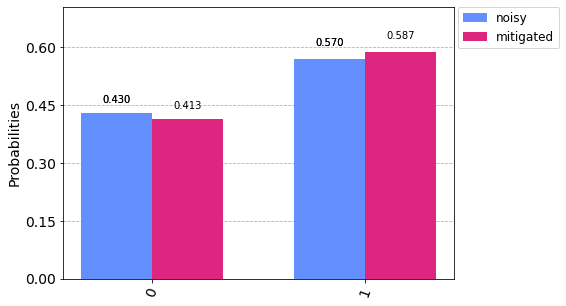

In [127]:
i = 4
plot_histogram([all_noisy_counts[i], all_mitigated_counts[i]], legend=['noisy', 'mitigated'])

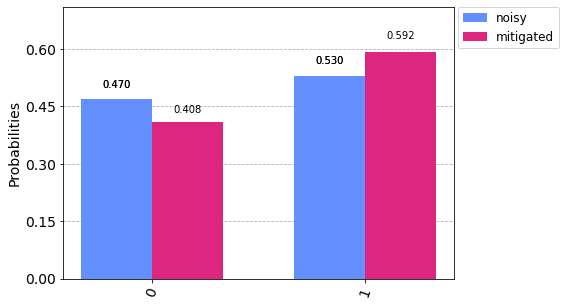

In [85]:
i = 1
plot_histogram([all_noisy_counts[i], all_mitigated_counts[i]], legend=['noisy', 'mitigated'])

In [115]:
secure_key_alice = get_secure_key_alice(initial_bit_string_5, known_indices_5)
secure_key_bob = get_secure_key_bob(final_bit_string_5, known_indices_5)
print(secure_key_alice)
print(secure_key_bob)

1111010110001011001001001101101010111001001100011
1111010110001011001001001101101010111001001100011


In [116]:
sent_digits = list(secure_key_alice)
corrected_digits = list(secure_key_bob)

In [117]:
"""
block size k(i, Q) as a function of the iteration number i and the quantum bit error rate Q:
k(1, Q) = 0.73 / Q
k(i + 1, Q) = 2 * k(i, Q)
"""
N = len(sent_digits)
Q = np.sum(np.array(sent_digits) != np.array(corrected_digits)) / N
if Q == 0.:
    Q = 0.001

In [118]:
#################### ------------ ####################
#################### BINARY SPLIT ####################
#################### ------------ ####################

# count parity
def parity(block):
    # return np.count_nonzero(block == "1") % 2
    return block.count("1") % 2


# binary split and correct odd parities
def bin_split(si = 0, fi = N, parity_cnt = 1):
    if fi < N:
        block_a = sent_digits[si : fi]
        block_b = corrected_digits[si : fi]
    else:
        block_a = sent_digits[si : N - 1] + [sent_digits[N - 1]]
        block_b = corrected_digits[si : N - 1] + [corrected_digits[N - 1]]

    # print(parity_cnt)
    # print(block_a)
    # print(block_b)
    if parity(block_a) != parity(block_b):
        if fi - si == 1:
            # "0" -> "1" and "1" -> "0"
            corrected_digits[si] = str(1 - int(corrected_digits[si]))
            return parity_cnt
        else:
            # right block bigger
            mid = si + (fi - si) // 2
            return bin_split(si, mid, parity_cnt + 1) + bin_split(mid, fi, parity_cnt + 1)
    else:
        return 1


In [119]:
#################### ------- ####################
#################### SHUFFLE ####################
#################### ------- ####################
import random


def getperm(iter_n, block):
    random.seed(iter_n)
    perm = list(range(len(block)))
    random.shuffle(perm)
    random.seed()  # optional, in order to not impact other code based on random
    return perm


def shuffle(iter_n, block):
    perm = getperm(iter_n, block)
    block[:] = [block[j] for j in perm]


def unshuffle(iter_n, block):
    perm = getperm(iter_n, block)
    res = [None] * len(block)
    for i, j in enumerate(perm):
        res[j] = block[i]
    block[:] = res

In [120]:
#################### ------- ####################
#################### CASCADE ####################
#################### ------- ####################
parity_checks = [0]
block_sizes = []

# shuffle, binary split blocks, unshuffle
def cascade(iter_n):

    k = min(int(0.73 / Q * 2 ** iter_n), N)
    print("Block Size:", k)
    block_sizes.append(k)

    shuffle(iter_n, sent_digits)
    shuffle(iter_n, corrected_digits)

    # binary split blocks and count parity checks
    iter_n_parity_checks = 0
    for i in range(0, N, k):
        if i + k <= N:
            iter_n_parity_checks += bin_split(i, i + k)
        else:
            iter_n_parity_checks += bin_split(i, N)

    # print("Parity Checks:", iter_n_parity_checks)
    parity_checks.append(parity_checks[-1] + iter_n_parity_checks)
    # print("Cumulative Parity Checks:", parity_checks[-1])

    unshuffle(iter_n, sent_digits)
    unshuffle(iter_n, corrected_digits)

In [121]:
errors = [Q]
for c in range(5):
    print()
    print("----------Testing Cascade " + str(c) + "----------")
    cascade(c)
    # print("S:", sent_digits)
    # print("C:", corrected_digits)
    error = np.mean(np.array(sent_digits) != np.array(corrected_digits))
    print("Error Rate:", error)
    print("Parity Checks:", parity_checks[-1])
    errors.append(error)

print("\n----------Final Results----------")
print("Final Block Size:", block_sizes[-1])
print("Final Error Rate:", errors[-1])
print("Final Parity Checks:", parity_checks[-1])
print("Final Parity Check Rate:", parity_checks[-1] / N)


----------Testing Cascade 0----------
Block Size: 49
Error Rate: 0.0
Parity Checks: 1

----------Testing Cascade 1----------
Block Size: 49
Error Rate: 0.0
Parity Checks: 2

----------Testing Cascade 2----------
Block Size: 49
Error Rate: 0.0
Parity Checks: 3

----------Testing Cascade 3----------
Block Size: 49
Error Rate: 0.0
Parity Checks: 4

----------Testing Cascade 4----------
Block Size: 49
Error Rate: 0.0
Parity Checks: 5

----------Final Results----------
Final Block Size: 49
Final Error Rate: 0.0
Final Parity Checks: 5
Final Parity Check Rate: 0.10204081632653061


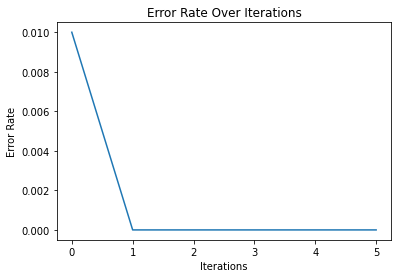

In [122]:
# Error Rate plot
plt.title("Error Rate Over Iterations")
plt.xlabel("Iterations")
plt.ylabel("Error Rate")
plt.plot(np.arange(len(errors)), errors)
plt.show()

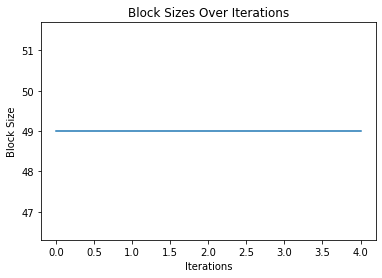

In [123]:
# Block Size plot
plt.title("Block Sizes Over Iterations")
plt.xlabel("Iterations")
plt.ylabel("Block Size")
plt.plot(np.arange(len(block_sizes)), block_sizes)
plt.show()

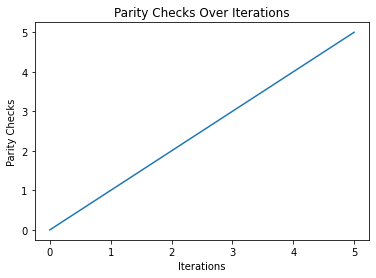

In [124]:
# Parity Check plot
plt.title("Parity Checks Over Iterations")
plt.xlabel("Iterations")
plt.ylabel("Parity Checks")
plt.plot(np.arange(len(parity_checks)), parity_checks)
plt.show()